In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import sys
sys.path.append('../..')
from vae import MyVAE
import time

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [2]:
digits = load_digits()
x = digits['data']
y = digits.target

In [3]:
method_list = ['PCA', 'KPCA', 'LE', 'Isomap', 'TSNE', 'UMAP', 'GPLVM', 'VAE', 'IKD']
d_latent_list = [2, 3, 5, 10]

In [5]:
def method_fit_transform(method, x, d_latent):
    if method == 'PCA':
        return PCA(n_components=d_latent).fit_transform(x)
    elif method == 'KPCA':
        return KernelPCA(n_components=d_latent, kernel='poly').fit_transform(x)
    elif method == 'LE':
        return SpectralEmbedding(n_components=d_latent).fit_transform(x)
    elif method == 'Isomap':
        return Isomap(n_components=d_latent).fit_transform(x)
    elif method == 'TSNE':
        if d_latent <= 3:
            return TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
        else:
            return TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42, method='exact').fit_transform(x)
    elif method == 'UMAP':
        return umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
    elif method == 'GPLVM':
        m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
        m_gplvm.likelihood.variance = 1.
        m_gplvm.optimize(max_iters=20, messages=0)
        z_gplvm = m_gplvm.X.values
        return z_gplvm
    elif method == 'VAE':
        return MyVAE(n_components=d_latent, epochs=100).fit_transform(x)
    elif method == 'IKD':
        return core.ikd_geodesic(x, d_latent=d_latent, ref_point='center', n_neighbors=7)

In [6]:
df_z = pd.DataFrame(columns=['z', 'method', 'd_latent', 'runtime'], dtype=object)

# preheat
for method in method_list:
    method_fit_transform(method, x, 2)
for method in method_list:
    for d_latent in d_latent_list:
        s = time.time()
        z = method_fit_transform(method, x, d_latent)
        e = time.time()
        df_z.loc[len(df_z)] = [z, method, d_latent, e-s]
        print(method, d_latent)

df_z.to_pickle(f'z.pkl')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


PCA 2
PCA 3
PCA 5
PCA 10
KPCA 2
KPCA 3
KPCA 5
KPCA 10
LE 2
LE 3
LE 5
LE 10


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Isomap 2


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Isomap 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Isomap 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Isomap 10


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


TSNE 2


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


TSNE 3


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


TSNE 5


 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


TSNE 10
UMAP 2
UMAP 3
UMAP 5
UMAP 10
GPLVM 2
GPLVM 3
GPLVM 5
GPLVM 10
VAE 2
VAE 3
VAE 5
VAE 10
IKD 2
IKD 3
IKD 5
IKD 10


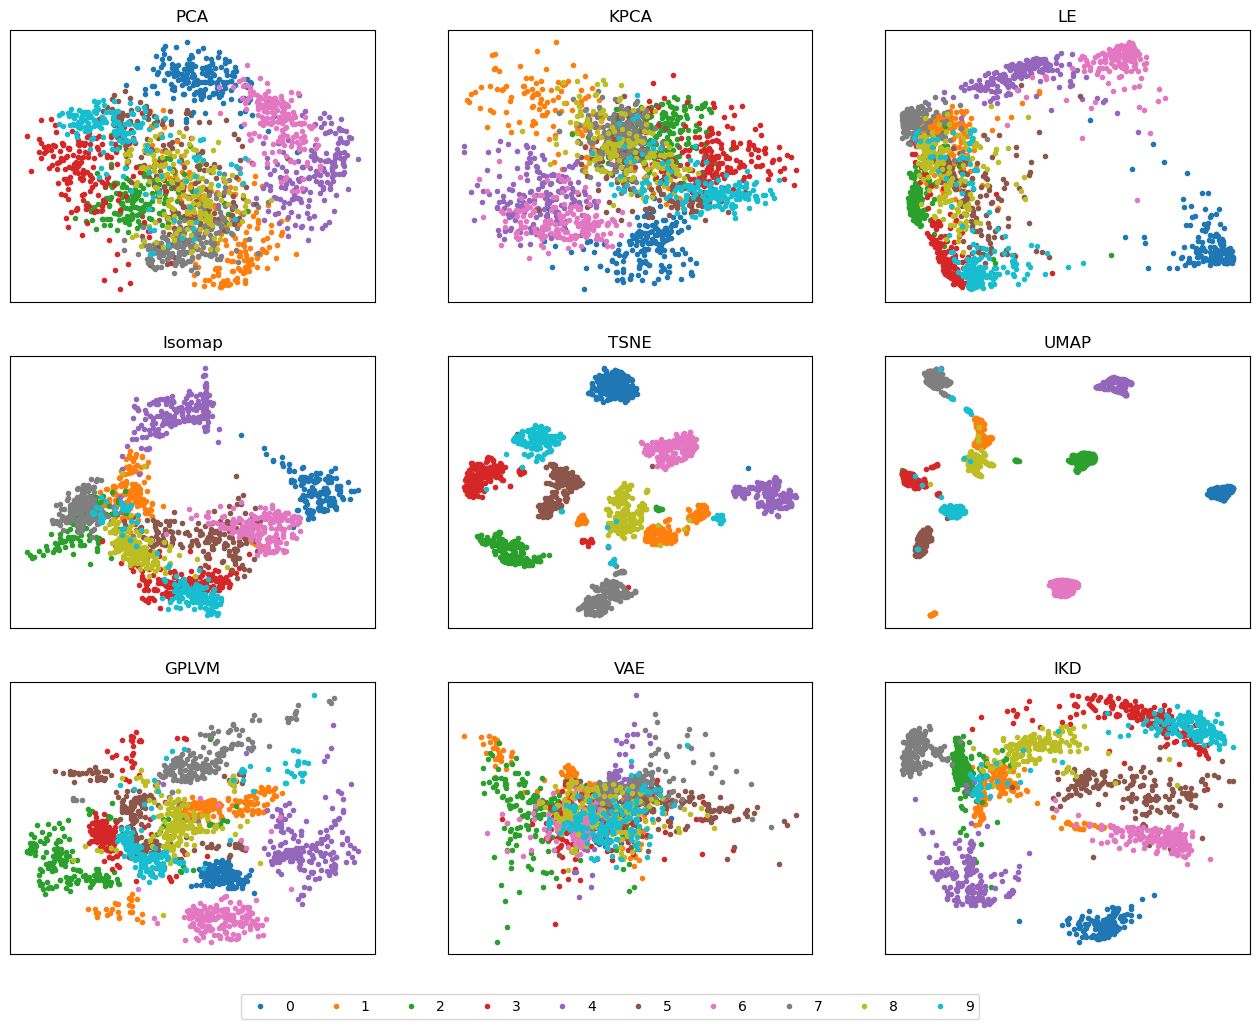

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
df_z = pd.read_pickle(f'z.pkl')
for i in range(3):
    for j in range(3):
        method = method_list[3*i+j]
        z = df_z[(df_z.d_latent == 2) & (df_z.method == method)].z.values[0]
        for k in np.unique(y):
            idx = y == k
            axs[i, j].plot(z[idx, 0], z[idx, 1], '.', label=f'{k}')
            axs[i, j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            axs[i, j].set_title(method)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=10)
fig.savefig('digits.pdf', bbox_inches='tight')

In [20]:
df_knn = pd.DataFrame(columns=['accuracy', 'runtime', 'method', 'd_latent', 'k', 'fold'])
k_list = [5, 10, 20]

for method in method_list:
    for d_latent in d_latent_list:
        temp = df_z[(df_z.method == method) & (df_z.d_latent == d_latent)]
        z = temp.z.values[0]
        runtime = temp.runtime.values[0]
        for k in k_list:
            clf = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(clf, z, y, cv=5)
            for i in range(5):
                df_knn.loc[len(df_knn)] = [scores[i], runtime, method, d_latent, k, i]
df_knn.to_csv('knn.csv')

<AxesSubplot:xlabel='k', ylabel='accuracy'>

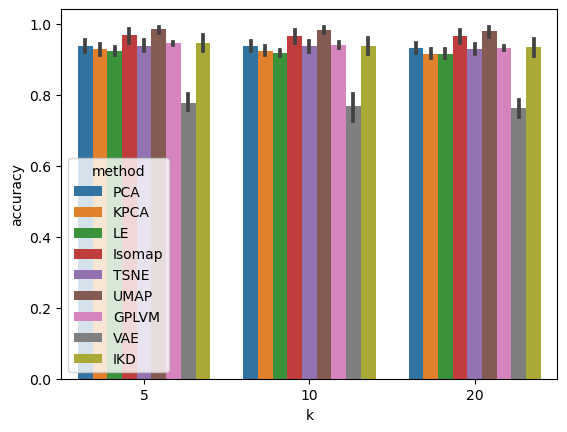

In [17]:
sns.barplot(data=df_knn[df_knn.d_latent==10], x='k', y='accuracy', hue='method')